In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn import metrics
from time import time
import matplotlib_inline
from matplotlib.animation import PillowWriter
import imageio
import os

# Datasets


In the first cell, there are four toy datasets for classification, featuring both linear and non-linear decision frontiers. Using decision trees, random forests, and AdaBoost, I will develop and analyze classifiers capable of handling non-linear decision boundaries.


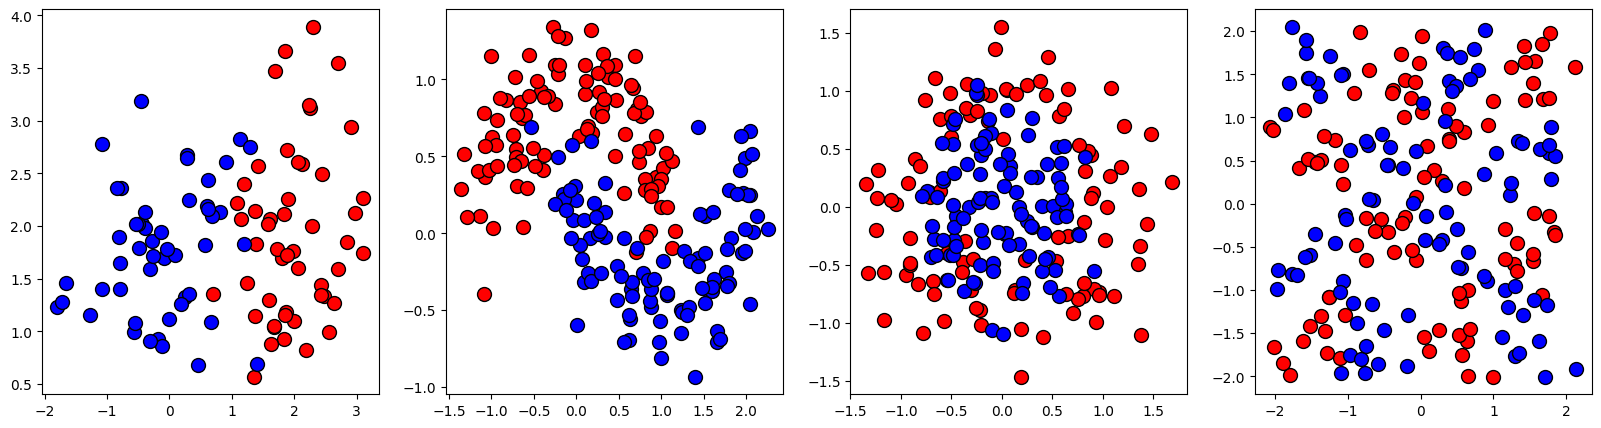

In [3]:
def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 2 + 1] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb
    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])-1

plot_colors = "rb"
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = [linearly_separable,
            make_moons(n_samples = 200, noise=0.2, random_state=0),
            make_circles(n_samples = 200, noise=0.3, factor=0.5, random_state=1),
            rand_checkers()]
fig, ax = plt.subplots(1, 4, figsize=(20,5))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    n_classes = len(np.unique(y))
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax[fi].scatter(X[idx, 0], X[idx, 1], c=color, edgecolor='black', s=100)
dataset = datasets[1]

In [4]:
def plot_tree(model, X, y, M=None,title=None):
    """Plot decision boundary of AdaBoost up to M iterations."""
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    if M != None:
      Z = model.predict(np.c_[xx.ravel(), yy.ravel()], M)
    else:
      Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    if title == None:
      plt.title(f'Iteration {M}' if M else 'Decision Boundary')
    else:
       plt.title(title)

# Impurity measures

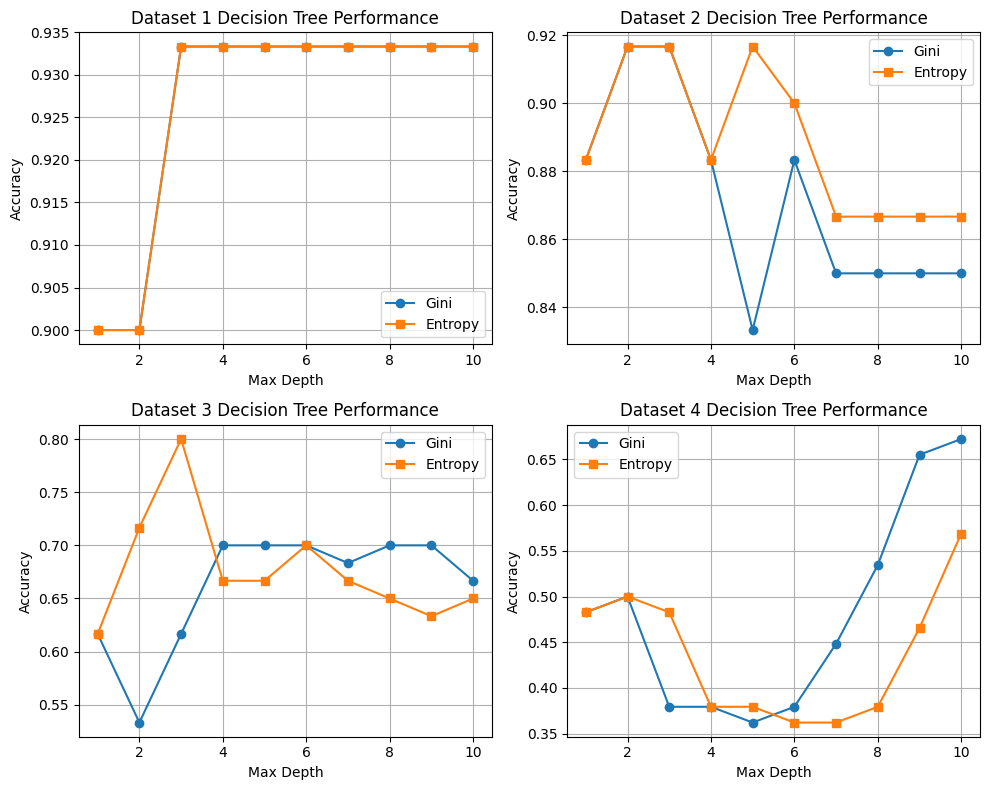

In [5]:
test_size = 0.3
random_state = 42

fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.ravel()

best_depths_gini = []
best_depths_entr = []

for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # 80% training and 20% test

    max_depth_values = range(1,11)
    scores_gini = []
    scores_entr = []

    for max_depth in max_depth_values:
        clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=random_state) #create classifier
        clf_gini = clf_gini.fit(X_train,y_train) # fit model
        score_gini = clf_gini.score(X_test, y_test)
        scores_gini.append(score_gini)
        
        clf_entr = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=random_state)
        clf_entr = clf_entr.fit(X_train,y_train)
        score_entr = clf_entr.score(X_test, y_test)
        scores_entr.append(score_entr)

    best_depths_gini.append(max_depth_values[np.argmax(scores_gini)])
    best_depths_entr.append(max_depth_values[np.argmax(scores_entr)])

    ax = axes[fi]
    ax.plot(max_depth_values, scores_gini, marker='o', label='Gini')
    ax.plot(max_depth_values, scores_entr, marker='s', label='Entropy')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Dataset {fi+1} Decision Tree Performance')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

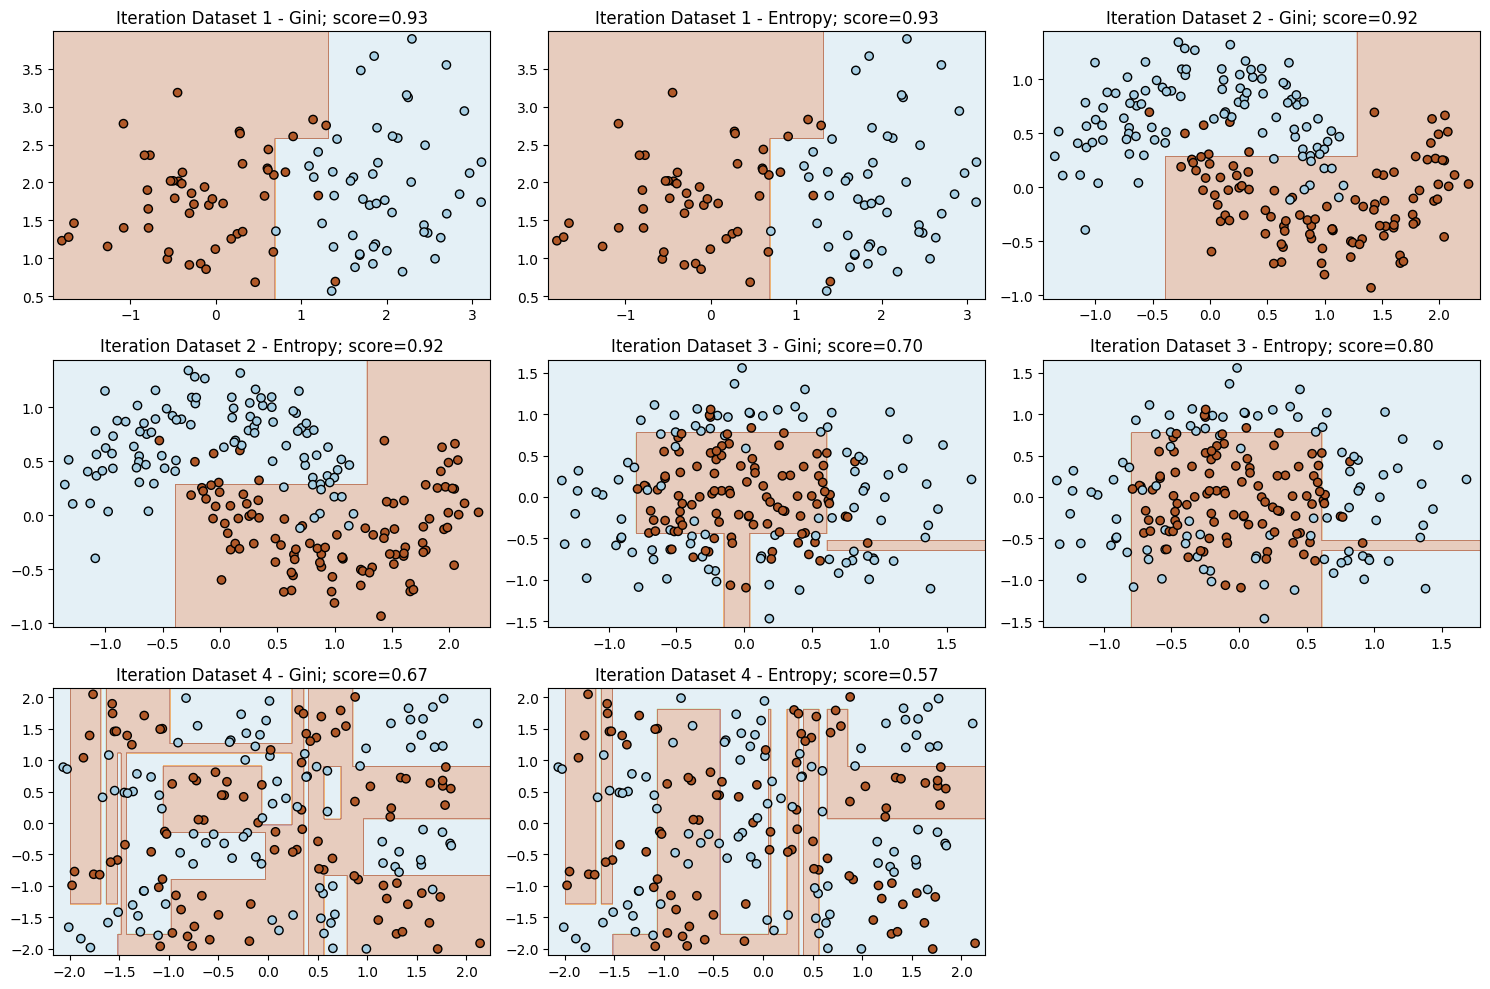

In [6]:
i=1
plt.figure(figsize=(15, 10))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    plt.subplot(3, 3, i) 
    i+=1

    max_depth_gini = best_depths_gini[fi]
    max_depth_entr = best_depths_entr[fi]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) # 80% training and 20% test

    clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=max_depth_gini, random_state=random_state) #create classifier
    clf_gini = clf_gini.fit(X_train,y_train) # fit model
    score_gini = clf_gini.score(X_test, y_test)
    
    clf_entr = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth_entr, random_state=random_state)
    clf_entr = clf_entr.fit(X_train,y_train)
    score_entr = clf_entr.score(X_test, y_test)

    plot_tree(clf_gini, X, y, f'Dataset {fi+1} - Gini; score={score_gini:.2f}' )
    plt.subplot(3, 3, i) 
    i+=1
    plot_tree(clf_entr, X, y, f'Dataset {fi+1} - Entropy; score={score_entr:.2f}')

plt.tight_layout()
plt.show()

# Ensembles

In [7]:
from sklearn.datasets import  load_diabetes, load_iris, load_digits

diabetes = load_diabetes()
iris = load_iris()
digits = load_digits()

def evaluate_model(name, X, y, data_transformation):
    print(f"\nTraining {name}")
    t0 = time()

    if data_transformation == 'Classification':
        score = cross_val_score(RandomForestClassifier(), X=X, y=y, cv=5, scoring='accuracy')
        print(f"Training completed in {time() - t0:.3f} seconds.")
        print(f"{name} Cross-Validation Score (Accuracy): Mean = {score.mean():.4f}, Std Dev = {score.std():.4f}")
        
    elif data_transformation == 'Regression':
        score = cross_val_score(RandomForestRegressor(), X=X, y=y, cv=5, scoring='r2')
        print(f"Training completed in {time() - t0:.3f} seconds.")
        print(f"{name} Cross-Validation Score (R2): Mean = {score.mean():.4f}, Std Dev = {score.std():.4f}")

# Evaluate on Diabetes dataset (Regression)
X_diabetes, y_diabetes = shuffle(diabetes.data, diabetes.target, random_state=0)
evaluate_model("Random Forest Regressor (Diabetes)", X_diabetes, y_diabetes, 'Regression')

# Evaluate on Iris dataset (Classification)
X_iris, y_iris = shuffle(iris.data, iris.target, random_state=0)
evaluate_model("Random Forest Classifier (Iris)", X_iris, y_iris, 'Classification')

# Evaluate on Digits dataset (Classification)
X_digits, y_digits = shuffle(digits.data, digits.target, random_state=0)
evaluate_model("Random Forest Classifier (Diabetes)", X_digits, y_digits, 'Classification')


Training Random Forest Regressor (Diabetes)
Training completed in 2.522 seconds.
Random Forest Regressor (Diabetes) Cross-Validation Score (R2): Mean = 0.4224, Std Dev = 0.0981

Training Random Forest Classifier (Iris)
Training completed in 1.124 seconds.
Random Forest Classifier (Iris) Cross-Validation Score (Accuracy): Mean = 0.9667, Std Dev = 0.0422

Training Random Forest Classifier (Diabetes)
Training completed in 3.069 seconds.
Random Forest Classifier (Diabetes) Cross-Validation Score (Accuracy): Mean = 0.9738, Std Dev = 0.0038


feature importance (Run a few times to understand)

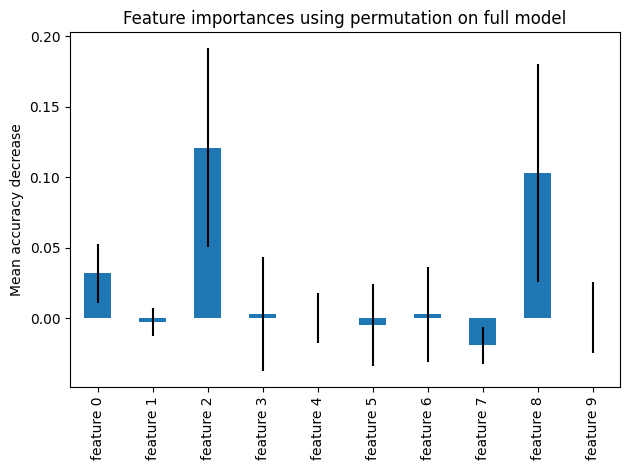

In [8]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dia = RandomForestRegressor(n_estimators=10)
dia.fit(X_train,y_train)
feature_names = [f"feature {i}" for i in range(X.shape[1])]

result = permutation_importance(
    dia, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

dia_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
dia_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()



By cusing permutation feature importance, we can observe how the accuracy of our model changes when we break the link between X and Y by permutating the values of X of the j-th variable for each variable. We can observe that over half of the features in our model have an importance lower than it's standard deviation meaning that varying them means little for our models accuracy, on the other hand the four features with higher importance cannot be permutated without causing a considerable amount of loss of accuracy, we could even try to train a model with only features 2 and 8 to have a simpler model with an accuracy that's not terrible, that even thought might not be usefull by itself helps the interpretability of th results

# Regression

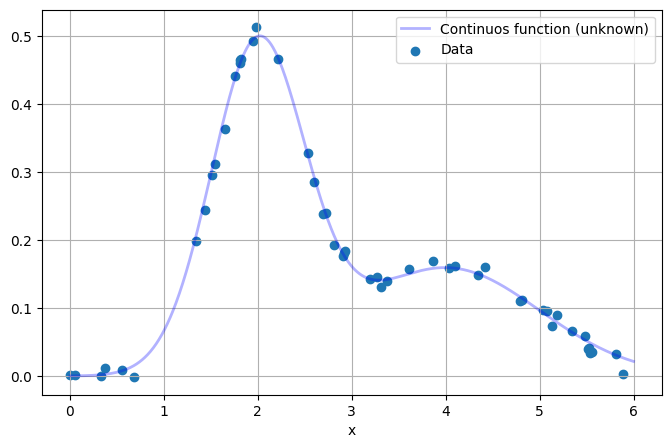

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
mean_1, std_1 = 2, 0.5  
mean_2, std_2 = 4, 1    
weight_1 = 0.6  
weight_2 = 0.4  
x = np.linspace(0, 6, 1000)
pdf_1 = norm.pdf(x, mean_1, std_1)
pdf_2 = norm.pdf(x, mean_2, std_2)
mixture_pdf = weight_1 * pdf_1 + weight_2 * pdf_2
plt.figure(figsize=(8, 5))
plt.plot(x, mixture_pdf, label="Continuos function (unknown)", alpha=.3, color="blue", lw=2)
plt.xlabel("x")
plt.grid(True)
Xr = np.sort(6 * np.random.rand(50))  
pdf_1 = norm.pdf(Xr, mean_1, std_1)
pdf_2 = norm.pdf(Xr, mean_2, std_2)
yr = weight_1 * pdf_1 + weight_2 * pdf_2
yr += np.random.normal(0,.01,len(yr))
plt.scatter(Xr, yr,label="Data")
plt.legend()
plt.show()

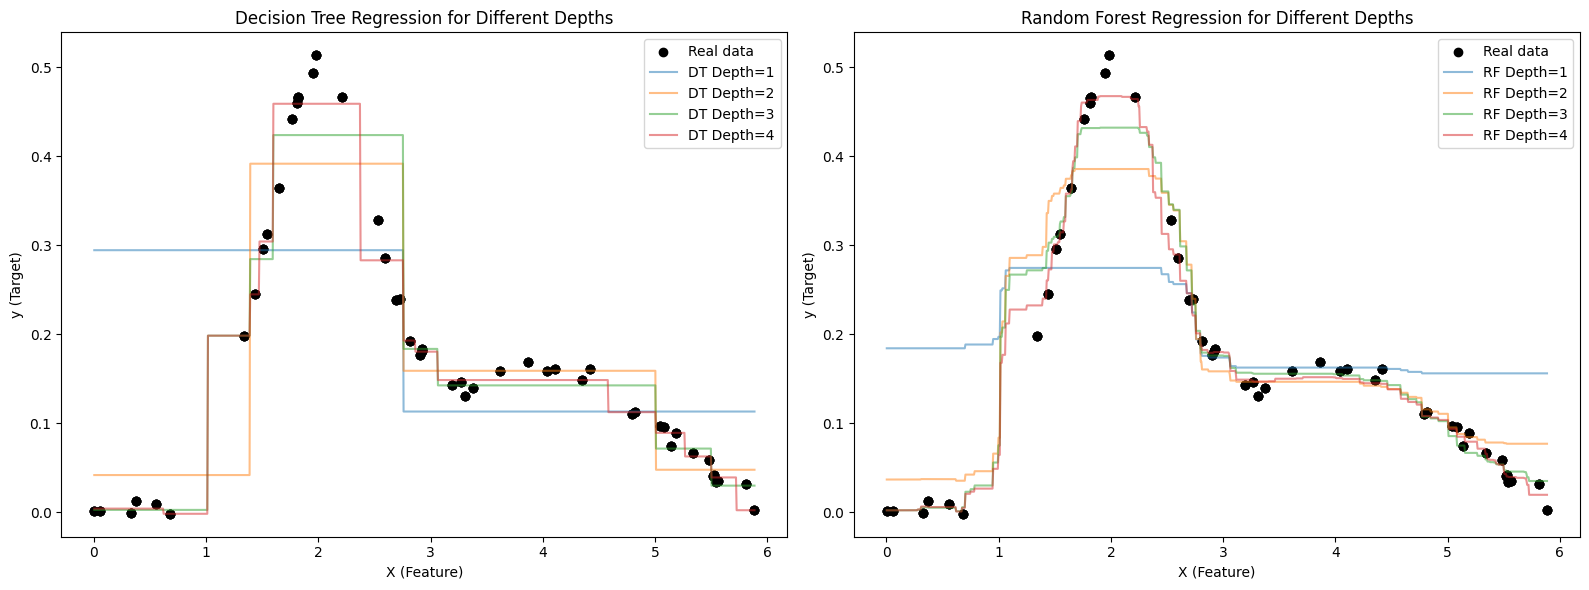

In [10]:
X = Xr.reshape(-1, 1)
y = yr

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 80% training and 20% test

max_depth_values = range(1,5)
scores_tree = []
scores_rf = []

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Two subplots: one for DecisionTree and one for RandomForest

for max_depth in max_depth_values:
    # Decision Tree Regressor
    clf_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=max_depth, random_state=1)
    clf_tree = clf_tree.fit(X_train, y_train)
    y_pred_tree = clf_tree.predict(X_test)
    score_tree = metrics.r2_score(y_test, y_pred_tree)
    scores_tree.append(score_tree)
    
    # Random Forest Regressor
    clf_rf = RandomForestRegressor(criterion='squared_error', max_depth=max_depth, random_state=1)
    clf_rf = clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    score_rf = metrics.r2_score(y_test, y_pred_rf)
    scores_rf.append(score_rf)
    
    # Plotting Decision Tree Regression results
    axs[0].scatter(X, y, color='black', label='Real data' if max_depth == 1 else "")
    X_grid = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1) 
    y_grid_tree = clf_tree.predict(X_grid)
    axs[0].plot(X_grid, y_grid_tree, label=f'DT Depth={max_depth}', alpha=.5)

    # Plotting Random Forest Regression results
    axs[1].scatter(X, y, color='black', label='Real data' if max_depth == 1 else "")
    X_grid = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1) 
    y_grid_rf = clf_rf.predict(X_grid)
    axs[1].plot(X_grid, y_grid_rf, label=f'RF Depth={max_depth}', alpha=.5)


axs[0].set_title('Decision Tree Regression for Different Depths')
axs[0].set_xlabel('X (Feature)')
axs[0].set_ylabel('y (Target)')
axs[0].legend(loc="best")

axs[1].set_title('Random Forest Regression for Different Depths')
axs[1].set_xlabel('X (Feature)')
axs[1].set_ylabel('y (Target)')
axs[1].legend(loc="best")

plt.tight_layout()
plt.show()

For the regression trees, predictions exhibit a piecewise constant structure, characteristic of tree-based models. Specifically:

Depth 2: Predictions form broad, distinct steps, reflecting fewer splits and coarser approximations of the data.

Depth 3 and 4: As depth increases, the predictions become more finely segmented, capturing localized variations and producing sharper, more abrupt transitions between constant regions.

For the Random Forest, predictions are notably smoother. This occurs because the forest aggregates predictions from an ensemble of trees, averaging out the abrupt jumps inherent in individual trees. The ensemble approach reduces overfitting and variance, resulting in a more gradual and generalized approximation of the underlying trend.

Impurity Criterion:
The models use the Mean Squared Error (MSE) as the impurity criterion. This metric minimizes the squared difference between observed and predicted values during node splitting, guiding the tree to partition data into regions with minimal variance

# AdaBoost

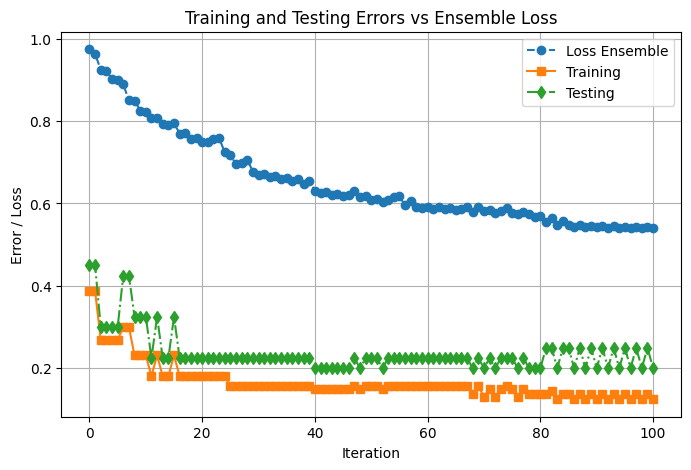

In [11]:
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
def compute_error(y, y_pred, w_m):
    y = np.array(y)
    y_pred = np.array(y_pred)
    err_t = np.sum(w_m*(y != y_pred))/np.sum(w_m)
    return err_t

def compute_alpha(error):
    alpha= np.log((1-error)/error)/2 if error != 0 else 0
    return alpha

def update_weights(w_i, alpha, y, y_pred):
    new_weights = w_i.copy()
    for i in range(len(new_weights)):
        if y[i] != y_pred[i]:
            new_weights[i] *= np.exp(alpha)
    new_weights /= np.sum(new_weights)  
    return new_weights


  
class AdaBoost:
    
    def __init__(self):
        self.alphas = [] # list of coefficients for the classifiers
        self.G_M = [] # list of weak clssifier
        self.M = None # number of iterations
        #save the error for plotting the evoltion of the performance
        self.training_errors = []
        self.testing_errors = []
        self.loss_ensemble = []
        self.stump_details = []
    
    def predict(self, X, M=None):
        if M is None:
            M=len(self.alphas)
        X=np.array(X)
        final_prediction = np.zeros(X.shape[0])
        for alpha, G_m in zip(self.alphas[:M], self.G_M[:M]):
            final_prediction += alpha * G_m.predict(X)
        return np.sign(final_prediction)



    def fit(self, X, y, M = 1, X_test=None, y_test=None):
        self.alphas = [] 
        self.training_errors, self.testing_errors = [],[]
        self.stump_details = []
        self.M = M
        Z=1

        # Iterate over M weak classifiers
        for m in range(0, M):
            # Set weights for current boosting iteration
            if m == 0:
                w_m = np.ones(len(y)) * 1 / len(y)  
            else:
                w_m = update_weights(w_m, alpha_m, y, y_pred)

            G_m = DecisionTreeClassifier(max_depth = 1)
            G_m.fit(X, y, sample_weight = w_m)
            y_pred = G_m.predict(X)
 

            feature = G_m.tree_.feature[0]
            threshold = G_m.tree_.threshold[0]
            self.stump_details.append((feature, threshold))

            
            error_m = compute_error(y, y_pred, w_m)
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            self.G_M.append(G_m)

            y_train_ensemble = self.predict(X)
            train_error = np.mean(y_train_ensemble != y)
            self.training_errors.append(train_error)


            F_train = np.sum([alpha * G.predict(X) for alpha, G in zip(self.alphas, self.G_M)], axis=0)
            train_loss = np.mean(np.exp(-y * F_train))
            self.loss_ensemble.append(train_loss)

            if X_test is not None and y_test is not None:
                y_test_ensemble = self.predict(X_test)
                test_error = np.mean(y_test_ensemble != y_test)
                self.testing_errors.append(test_error)

        return(self)

        
        

dataset = datasets[2]
X = dataset[0]
y = dataset[1]*2-1 # For the AdaBoost y={-1,+1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ab = AdaBoost()
ab.fit(X_train, y_train, M = 101, X_test=X_test, y_test=y_test)
plt.figure(figsize=(8, 5))
plt.plot(ab.loss_ensemble, label="Loss Ensemble", linestyle="--", marker="o")
plt.plot(ab.training_errors, label="Training", linestyle="-", marker="s")
plt.plot(ab.testing_errors, label="Testing", linestyle="-.", marker="d")
plt.xlabel("Iteration")
plt.ylabel("Error / Loss")
plt.title("Training and Testing Errors vs Ensemble Loss")
plt.legend()
plt.grid(True)
plt.show()

In [21]:

def plot_iterations(ensemble, X, y, stump_feature, stump_threshold, iteration, save_path=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    
    # Plot ensemble decision boundary
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    Z = ensemble.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    
    # Plot stump's decision boundary
    for m in range(iteration):
        if stump_feature[m] == 0:
            plt.axvline(x=stump_threshold[m], color='black', linestyle=':', linewidth=0.8)
        else:
            plt.axhline(y=stump_threshold[m], color='black', linestyle=':', linewidth=0.8)
    if stump_feature[m] == 0:
        plt.axvline(x=stump_threshold[m], color='r', linestyle='-', linewidth=2)
    else:
        plt.axhline(y=stump_threshold[m], color='r', linestyle='-', linewidth=2)
    
    plt.title(f'AdaBoost Ensemble (Iteration {iteration})')
    
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        plt.close()  # Close the figure to free memory
    else:
        plt.show()

#temporary directory to save frames
temp_dir = "adaboost_frames"
os.makedirs(temp_dir, exist_ok=True)


X, y = datasets[1]
y = 2 * y - 1  # Convert labels to {-1, +1}
M = 60

ab = AdaBoost().fit(X, y, M)
features, thresholds = zip(*ab.stump_details)

for m in range(M):
    ab_partial = AdaBoost()
    ab_partial.alphas = ab.alphas[:m+1]
    ab_partial.G_M = ab.G_M[:m+1]
    frame_path = os.path.join(temp_dir, f"frame_{m:03d}.png")
    plot_iterations(ab_partial, X, y, features, thresholds, m+1, save_path=frame_path)

# Compile frames into a GIF
images = []
for m in range(M):
    frame_path = os.path.join(temp_dir, f"frame_{m:03d}.png")
    images.append(imageio.v2.imread(frame_path))

imageio.mimsave('adaboost_evolution_b.gif', images, duration=0.4)

# Remove temporary frames (optional)
import shutil
shutil.rmtree(temp_dir)

plot the frames from the gif:

In [13]:
#X, y = datasets[1]
#y = 2 * y - 1  
#M = 60

# Train AdaBoost for 50 iterations
#ab = AdaBoost().fit(X, y, M)
#feature, threshold = zip(*ab.stump_details)

# Plot ensemble and stump
#for m in range(M):
#    ab_partial = AdaBoost()
#    ab_partial.alphas = ab.alphas[:m+1]
#    ab_partial.G_M = ab.G_M[:m+1]
#    plot_iterations(ab_partial, X, y, feature, threshold, m+1)

In [14]:
def plot_ada(dataset,M=50):
    X, y = dataset
    y = 2 * y - 1  

    # Train AdaBoost for 50 iterations
    ab = AdaBoost().fit(X, y, M)
    i=1
    # Plot decision boundary each 5 iterations
    plt.figure(figsize=(15, 10))
    for m in np.linspace(1,M,9): 
        plt.subplot(3, 3, i) 
        plot_tree(ab, X, y, int(m))
        i+=1
    plt.suptitle(f'Dataset 1')
    plt.show()  

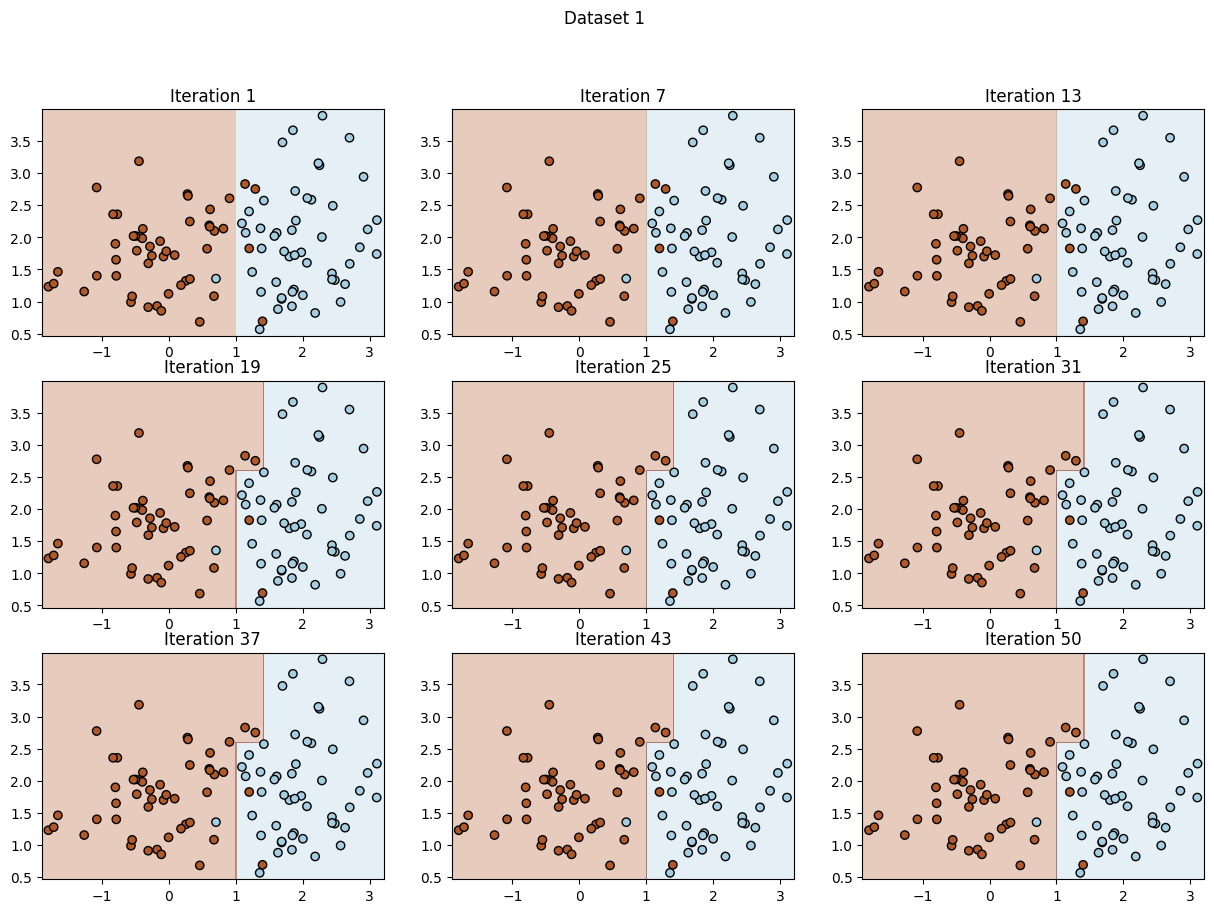

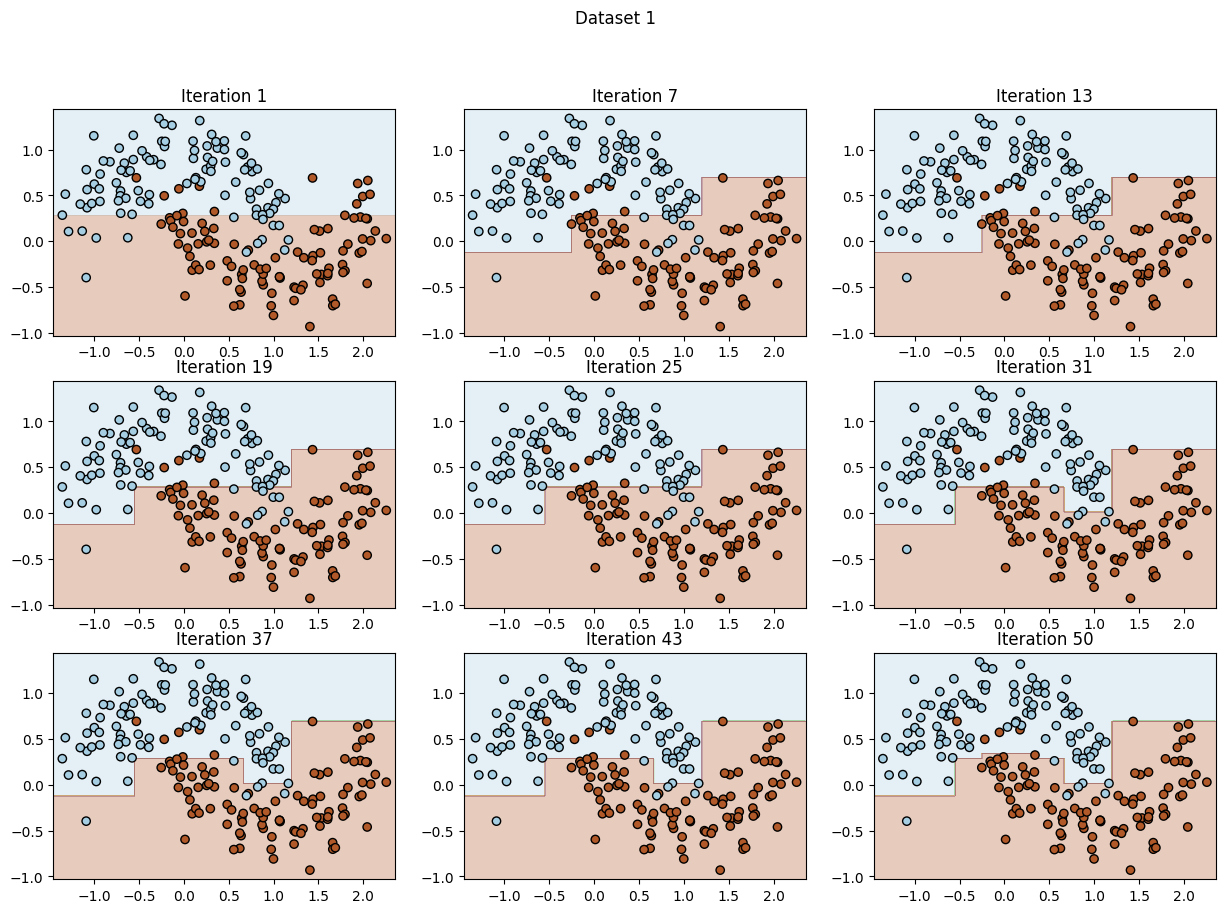

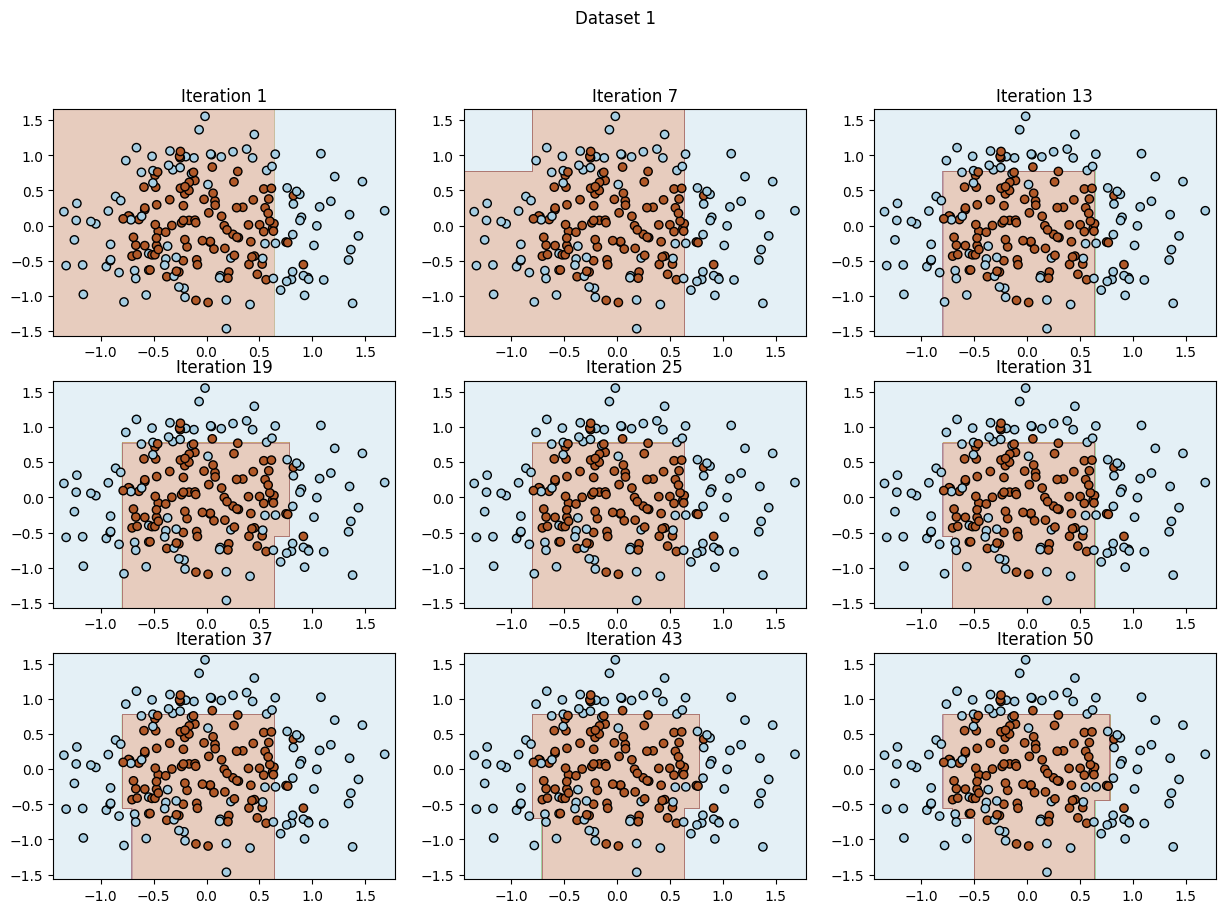

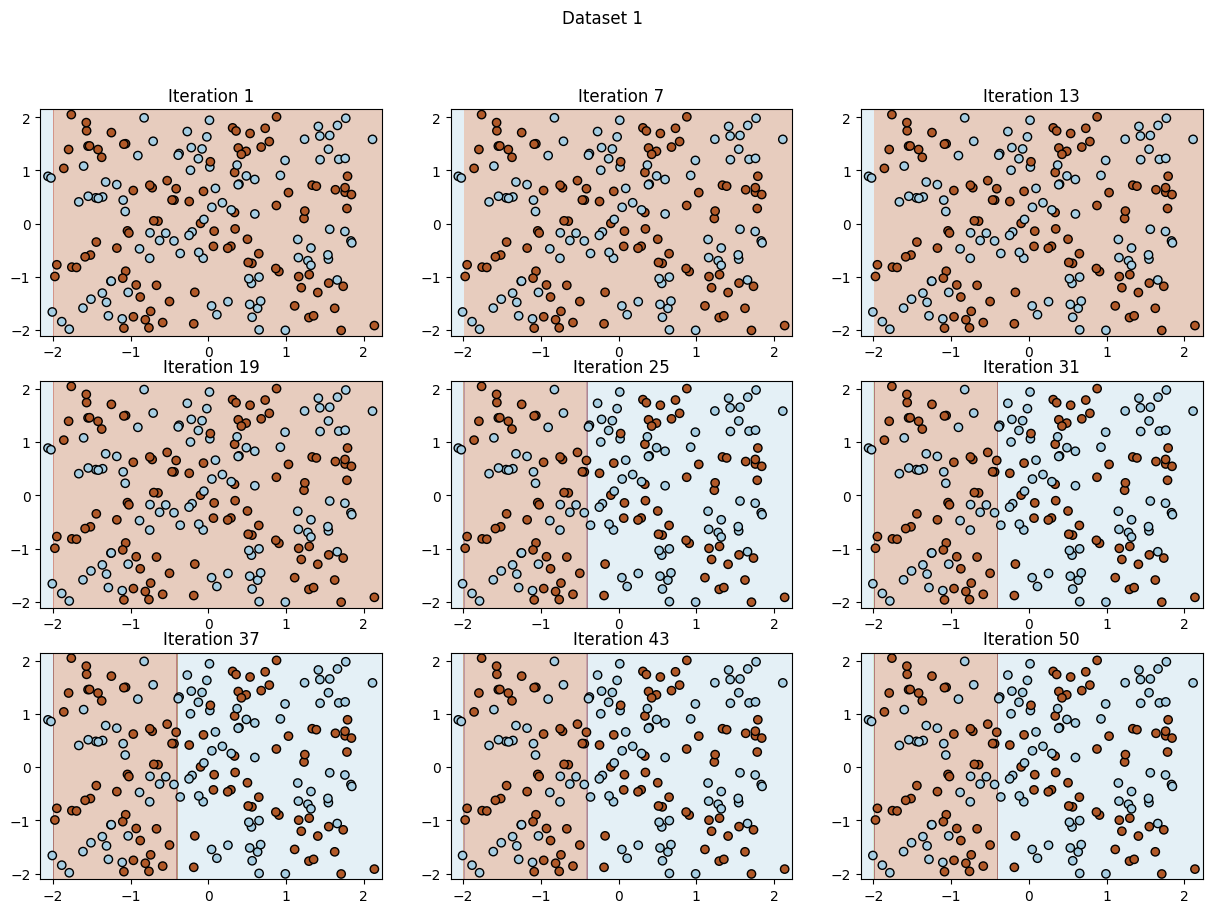

In [15]:
plot_ada(datasets[0],50)
plot_ada(datasets[1],50)
plot_ada(datasets[2],50)
plot_ada(datasets[3],50)

# AUC ROC - AUC PR

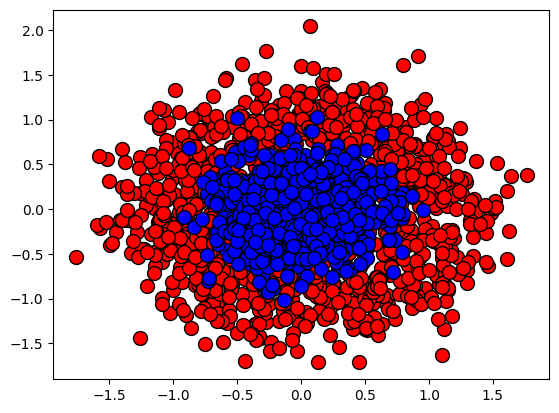

In [16]:
X,y = make_circles(n_samples = 2000, noise=0.3, factor=0.1)
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, edgecolor='black', s=100)

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_pr(proba, y_true):
    # Compute ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_true, proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    # Compute Precision-Recall curve and PR AUC
    precision, recall, _ =  precision_recall_curve(y_true, proba)
    pr_auc = average_precision_score(y_true, proba) 
    
    # Plot ROC Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    
    # Plot PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()


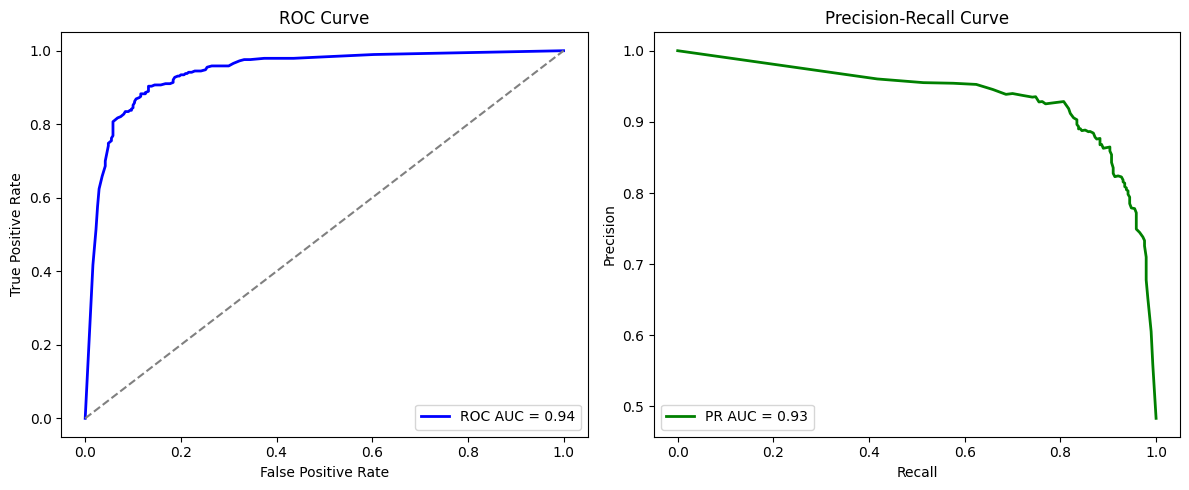

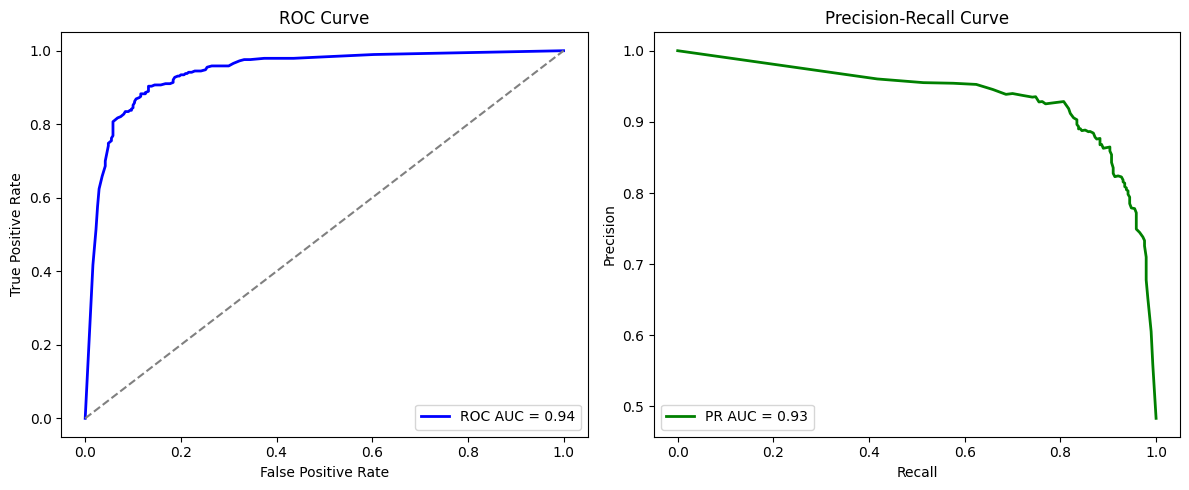

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

proba_test = clf.predict_proba(X_test)[:, 1]

plot_roc_pr(proba_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

proba_test = clf.predict_proba(X_test)[:, 1]

plot_roc_pr(proba_test, y_test)

In [19]:
def subsample_data(X, y, keep_ratio=0.4):
    """Subsample dataset to keep all class 1 and only a fraction of class 0."""
    
    class_1_mask = y == 0
    class_0_mask = y == 1
    X_class_1 = X[class_1_mask]
    y_class_1 = y[class_1_mask]
    X_class_0 = X[class_0_mask]
    y_class_0 = y[class_0_mask]
    np.random.seed(0)
    sample_indices = np.random.choice(len(X_class_0), int(len(X_class_0) * keep_ratio), replace=False)
    X_class_0 = X_class_0[sample_indices]
    y_class_0 = y_class_0[sample_indices]
    X_subsampled = np.vstack((X_class_1, X_class_0))
    y_subsampled = np.hstack((y_class_1, y_class_0))
    
    return X_subsampled, y_subsampled

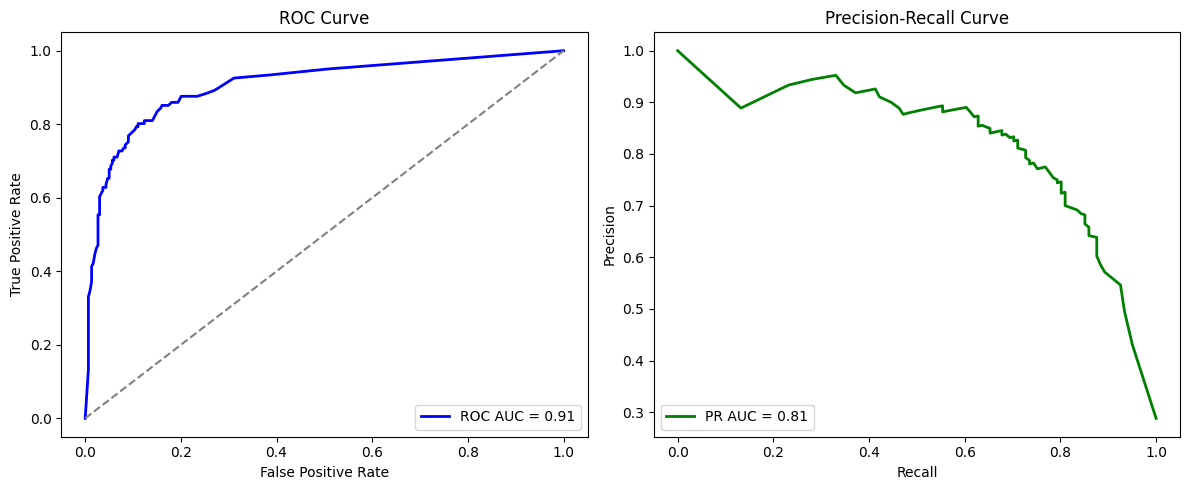

In [20]:
X_subsampled, y_subsampled = subsample_data(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_subsampled, y_subsampled, test_size=0.3, random_state=0)

clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

proba_test = clf.predict_proba(X_test)[:, 1]

plot_roc_pr(proba_test, y_test)